In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

In [2]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\vaibh\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [14]:
training_data, testing_data = imdb['train'],imdb['test']

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for s, l in imdb['train']:
    training_sentences.append(str(s.numpy(), encoding='utf8'))
    training_labels.append(l.numpy())

for s, l in imdb['test']:
    testing_sentences.append(str(s.numpy(),encoding='utf8'))
    testing_labels.append(l.numpy())
    
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [15]:
vocab_size = 10000
maxlen = 120
oov_token = '<OOV>'
trunc_type = 'post'
embedding_dim = 16

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=maxlen, truncating=trunc_type)

testing_seq = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(testing_seq, maxlen=maxlen, truncating=trunc_type)

In [24]:
reverse_word_index = dict([(value , key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'<pad>') for i in text])
print(decode_review(padded[0]))
#print(padded[0])
print(training_sentences[0])

<pad> <pad> <pad> this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece.

In [26]:
from keras.layers import Dense, Embedding, Flatten
from keras.models import Sequential

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Flatten(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [27]:
epochs = 10
model.fit(padded, training_labels_final, epochs=epochs, validation_data=(test_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 3s 3ms/step - loss: 0.5060 - accuracy: 0.7249 - val_loss: 0.3782 - val_accuracy: 0.8291
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 0.2420 - accuracy: 0.9076 - val_loss: 0.4036 - val_accuracy: 0.8237
Epoch 3/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0891 - accuracy: 0.9774 - val_loss: 0.5123 - val_accuracy: 0.8095
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0202 - accuracy: 0.9979 - val_loss: 0.5962 - val_accuracy: 0.8067
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.6693 - val_accuracy: 0.8086
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.7315 - val_accuracy: 0.8095
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 8.1692e-04 - accuracy: 1.0000 - val_loss: 0.7770 - val_accuracy: 0.8102
Ep

In [28]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [31]:
weights[1]

array([ 0.01711142,  0.03656453,  0.01410575,  0.00871815, -0.0237266 ,
        0.10129777, -0.07441868, -0.01998794, -0.04486354,  0.08478618,
        0.0757767 ,  0.02596737,  0.06548608,  0.01087508,  0.04456181,
        0.00135327], dtype=float32)

In [32]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embeddings])+'\n')
out_v.close()
out_m.close()
    

In [2]:
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\vaibh\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

In [4]:
tokenizer = info.features['text'].encoder

In [5]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [6]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print(tokenized_string)
original_string = tokenizer.decode(tokenized_string)
print(original_string)

[6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
TensorFlow, from basics to mastery


In [7]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [15]:
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.models import Sequential
embedding_dim = 64
model = Sequential([
    Embedding(tokenizer.vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [16]:
epochs = 10
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 10s 22ms/step - loss: 0.6800 - accuracy: 0.5920 - val_loss: 0.6393 - val_accuracy: 0.7588
Epoch 2/10
391/391 [==============================] - 9s 24ms/step - loss: 0.5400 - accuracy: 0.7973 - val_loss: 0.4787 - val_accuracy: 0.7894
Epoch 3/10
391/391 [==============================] - 10s 25ms/step - loss: 0.3865 - accuracy: 0.8639 - val_loss: 0.3708 - val_accuracy: 0.8632
Epoch 4/10
391/391 [==============================] - 10s 25ms/step - loss: 0.3078 - accuracy: 0.8897 - val_loss: 0.3329 - val_accuracy: 0.8706
Epoch 5/10
391/391 [==============================] - 10s 25ms/step - loss: 0.2665 - accuracy: 0.9028 - val_loss: 0.3185 - val_accuracy: 0.8738
Epoch 6/10
391/391 [==============================] - 9s 24ms/step - loss: 0.2400 - accuracy: 0.9136 - val_loss: 0.3088 - val_accuracy: 0.8785
Epoch 7/10
391/391 [==============================] - 10s 26ms/step - loss: 0.2185 - accuracy: 0.9224 - val_loss: 0.3067 - val_accuracy: 0

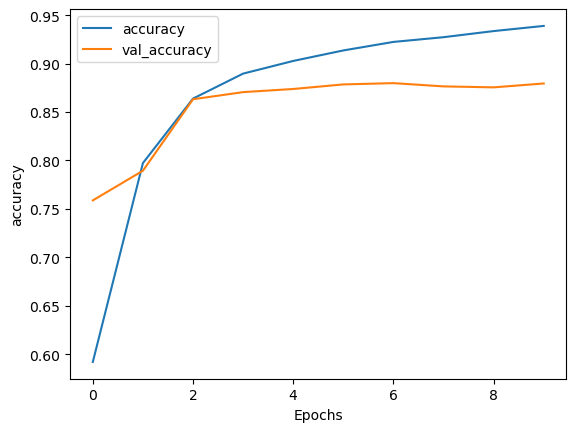

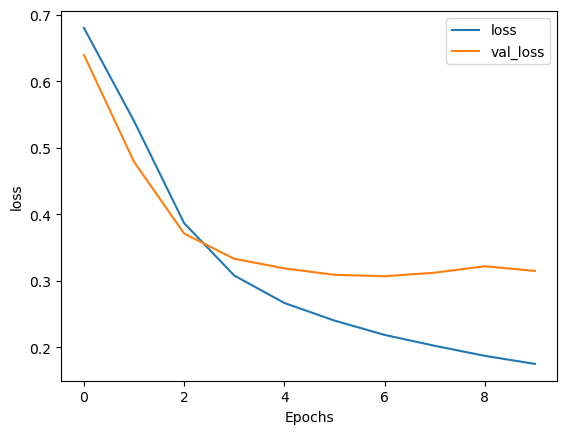

In [17]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


(8185, 64)
